# Palta OBB — Entrenamiento, Inferencia y Exportación (YOLOv8-OBB)

Este notebook documenta el flujo completo para entrenar un modelo OBB con Ultralytics YOLOv8, realizar inferencias y exportar a ONNX.

Notas:
- Si no tienes GPU/CUDA, puedes usar CPU (más lento) estableciendo `DEVICE="cpu"`.
- Ajusta rutas y parámetros a tu entorno/dataset (por ejemplo `configs/data.yaml`).

In [5]:
# Información de entorno y chequeo de GPU
import sys, platform
import torch
import ultralytics

print(f'Python: {sys.version.split()[0]} en {platform.system()} {platform.release()}')
print(f'Ultralytics: {ultralytics.__version__}')
print(f'Torch: {torch.__version__} | CUDA disponible: {torch.cuda.is_available()}')
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No detectada")

if torch.cuda.is_available():
    try:
        print('GPU:', torch.cuda.get_device_name(0))
    except Exception as e:
        print('GPU detectada pero no identificada:', e)

# Por defecto, usa GPU si está disponible; si no, CPU
DEVICE = '0' if torch.cuda.is_available() else 'cpu'
DEVICE

Python: 3.12.5 en Windows 11
Ultralytics: 8.3.192
Torch: 2.6.0+cu124 | CUDA disponible: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


'0'

## Parámetros del experimento

In [17]:
from pathlib import Path
ROOT = next(p for p in [Path.cwd(), *Path.cwd().parents] if (p/'configs'/'data.yaml').exists())
DATA_YAML = str(ROOT/'configs'/'data.yaml')
BASE_MODEL = 'yolov8n-obb.pt'            # n/s/m/l/x-obb.pt
PROJECT   = 'outputs'
NAME      = 'nb_train_obb'               # nombre del experimento
EPOCHS    = 80
IMGSZ     = 1024                         # reduce a 640 si entrenas en CPU
BATCH     = -1                           # -1 = auto
PATIENCE  = 30                           # early stopping
# Si no tienes GPU, fuerza CPU: DEVICE = 'cpu'
DEVICE = DEVICE  # deja así o cambia a 'cpu' explícitamente

print('DATA_YAML =', DATA_YAML)
print('BASE_MODEL=', BASE_MODEL)
print('DEVICE    =', DEVICE)

DATA_YAML = c:\Users\benja\OneDrive\Desktop\GitHub 2025\palta-obb-yolov\configs\data.yaml
BASE_MODEL= yolov8n-obb.pt
DEVICE    = 0


## Fijar semillas (reproducibilidad)

In [18]:
import random, numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print('Seed fija a 42')

Seed fija a 42


## Entrenamiento (YOLOv8-OBB)

In [19]:
from ultralytics import YOLO

model = YOLO(BASE_MODEL)
results = model.train(
    task='obb',
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=DEVICE,
    project=PROJECT,
    name=NAME,
    pretrained=True,
    optimizer='auto',
    lr0=0.01,
    patience=PATIENCE,
    verbose=True
)
results

Ultralytics 8.3.192  Python-3.12.5 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\benja\OneDrive\Desktop\GitHub 2025\palta-obb-yolov\configs\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=nb_train_obb6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022F4F6B9040>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

## Ruta a los pesos entrenados (`best.pt`)

In [21]:
from pathlib import Path
runs = sorted(Path('outputs').glob('nb_train_obb*/weights/best.pt'))
assert runs, 'No se encontró best.pt en outputs/*/weights'
BEST = runs[-1]
print('BEST =', BEST)

BEST = outputs\nb_train_obb6\weights\best.pt


In [22]:
print('BEST =', BEST)
assert BEST.exists(), 'No se encontró best.pt — confirma que el entrenamiento terminó y revisa la ruta.'

BEST = outputs\nb_train_obb6\weights\best.pt


## Inferencia en imágenes (y visualización inline)

TEST_DIR = ..\test\paltas verdes
Procesando: palta verde 2.jpeg
Results saved to outputs\predict\nb_run10


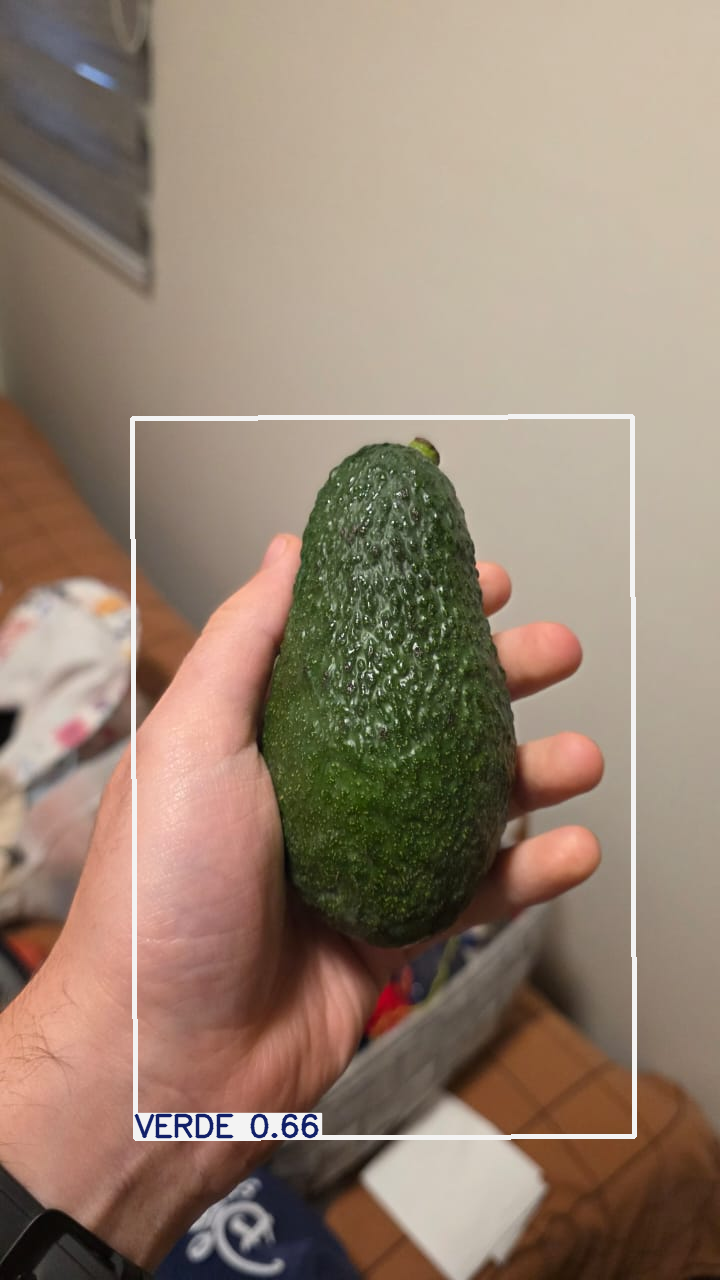

Procesando: palta verde 3.jpeg
Results saved to outputs\predict\nb_run11


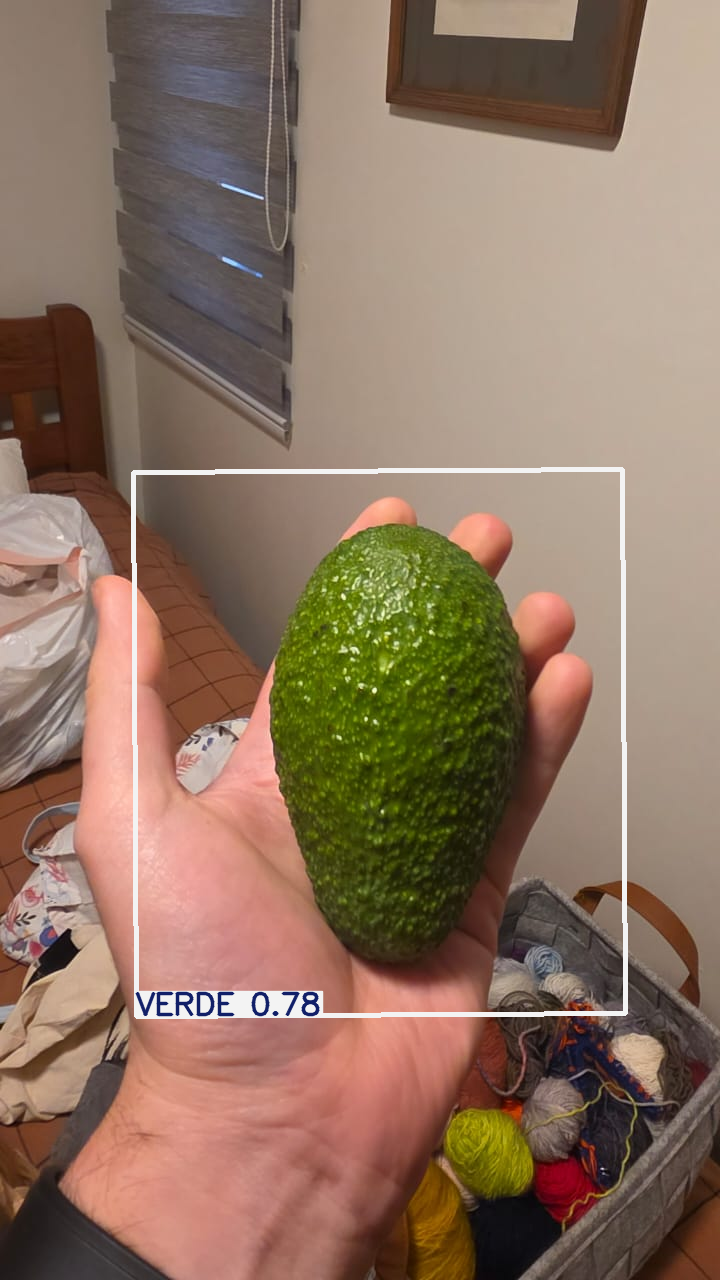

Procesando: palta verde 4.jpeg
Results saved to outputs\predict\nb_run12


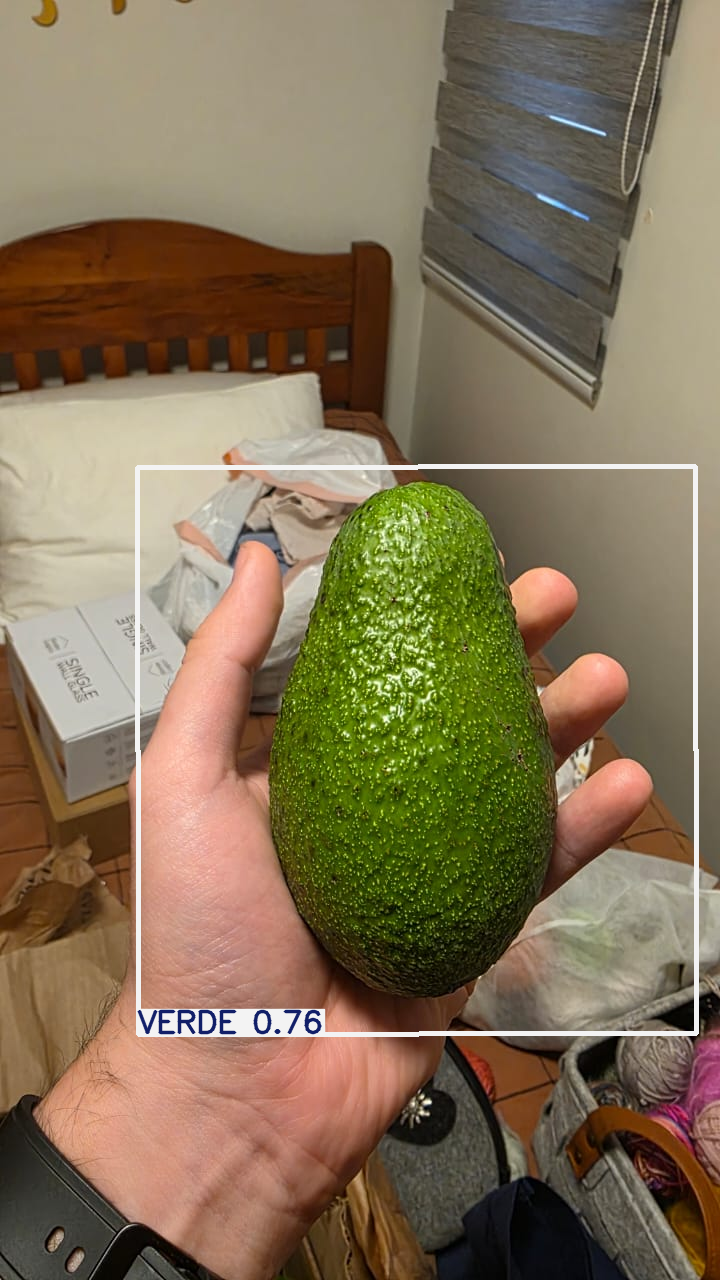

Procesando: palta verde 5.jpeg
Results saved to outputs\predict\nb_run13


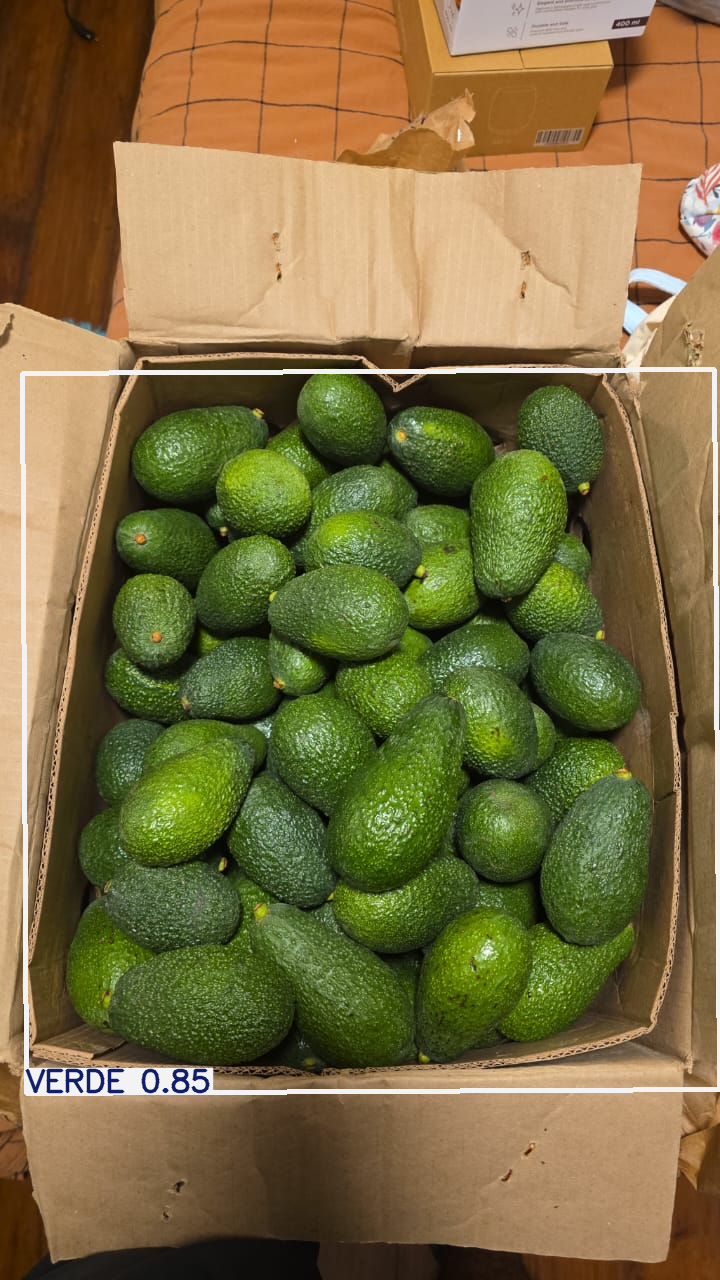

Procesando: palta verde 6.jpeg
Results saved to outputs\predict\nb_run14


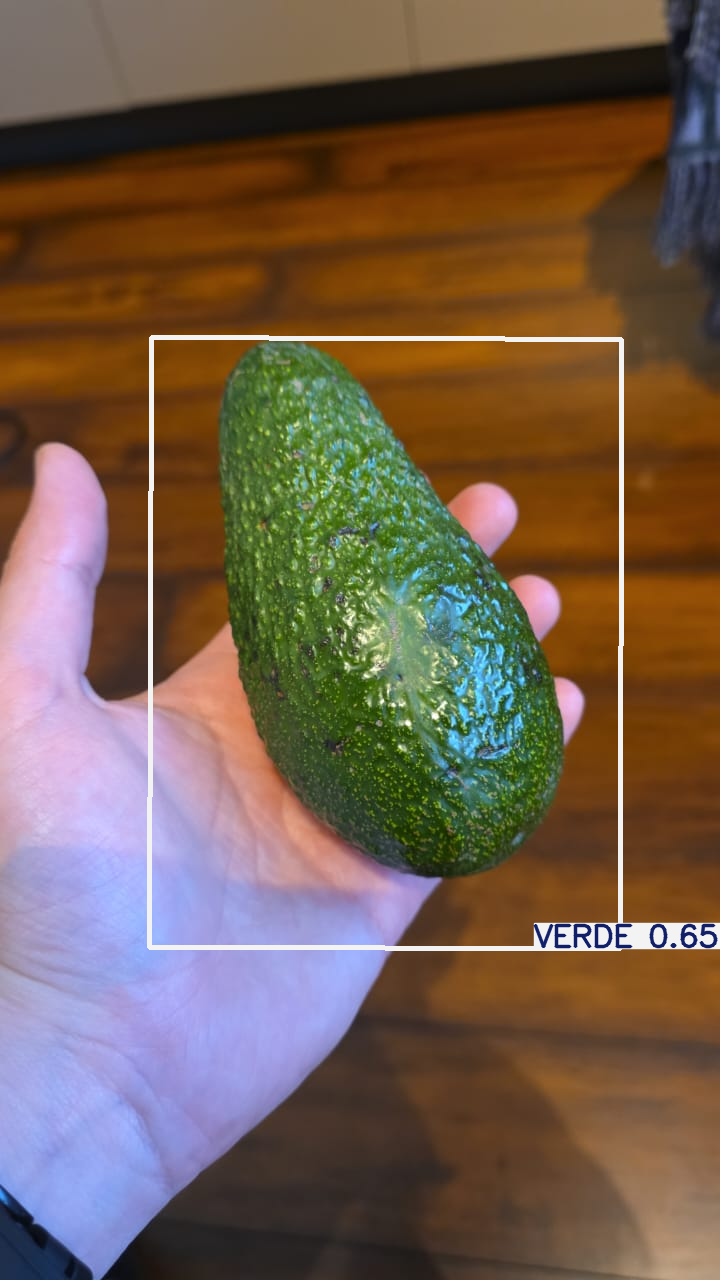

Procesando: palta verde.jpeg
Results saved to outputs\predict\nb_run15


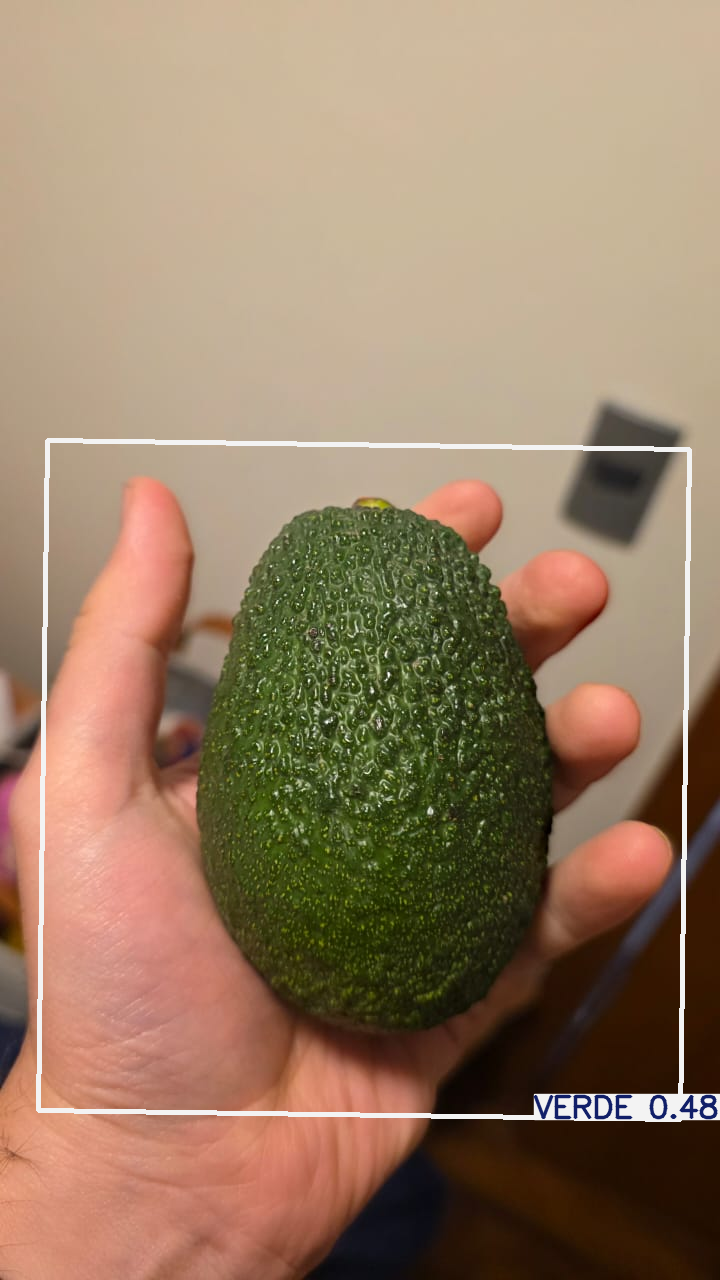

In [33]:
from pathlib import Path
from PIL import Image
import cv2, os

# Carpeta de prueba con imágenes
TEST_DIR = Path("../test/paltas verdes")   # ajusta la ruta a tu carpeta
print('TEST_DIR =', TEST_DIR)

# Filtrar extensiones de imagen válidas
valid_exts = {".jpg", ".jpeg", ".png"}

if TEST_DIR.exists() and TEST_DIR.is_dir():
    for file in TEST_DIR.iterdir():
        if file.suffix.lower() in valid_exts:
            print(f"Procesando: {file.name}")
            pred = YOLO(str(BEST)).predict(
                task='obb',
                source=str(file),
                imgsz=IMGSZ,
                device=DEVICE,
                save=True,
                project=str(Path(PROJECT)/'predict'),
                name='nb_run',
                verbose=False
            )
            # Mostrar primeras predicciones inline
            shown = 0
            for r in pred:
                img_bgr = r.plot()
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                display(Image.fromarray(img_rgb))
                shown += 1
                if shown >= 3:
                    break
else:
    print('Ajusta TEST_DIR a una ruta válida para ejecutar inferencia.')


## Validación opcional (`val`)

In [23]:
# Ejecuta validación sobre el conjunto de val definido en data.yaml
# (esto puede tardar)
val_res = YOLO(str(BEST)).val(task='obb', data=DATA_YAML, imgsz=IMGSZ, device=DEVICE)
val_res

Ultralytics 8.3.192  Python-3.12.5 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv8n-obb summary (fused): 81 layers, 3,077,804 parameters, 0 gradients, 8.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 439.878.2 MB/s, size: 86.1 KB)
val: Scanning C:\Users\benja\OneDrive\Desktop\GitHub 2025\palta-obb-yolov\data\roboflow\valid\labels.cache... 139 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 139/139  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.1it/s 4.4s0.3sss
                   all        139        132      0.954          1      0.987      0.931
                MADURA         52         52      0.974          1      0.992      0.932
           SOBREMADURA         40         40      0.999          1      0.995      0.945
                 VERDE         40         40      0.889          1      0.975      0.916
Speed: 1.1ms preprocess, 9.0ms inference, 0.0ms loss, 5.8ms po

ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022F569BEA20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

## Exportación a ONNX

In [26]:
# Exporta el modelo entrenado a ONNX
export_path = YOLO(str(BEST)).export(format='onnx', opset=12, dynamic=True, imgsz=IMGSZ)
export_path

Ultralytics 8.3.192  Python-3.12.5 torch-2.6.0+cu124 CPU (12th Gen Intel Core(TM) i7-12700H)
YOLOv8n-obb summary (fused): 81 layers, 3,077,804 parameters, 0 gradients, 8.3 GFLOPs

PyTorch: starting from 'outputs\nb_train_obb6\weights\best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 8, 21504) (6.2 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.65', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Defaulting to user installation because normal site-packages is not writeable

requirements: AutoUpdate success  1.8s
WARNING requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.0 opset 12...
WARNING ONNX: simplifier failure: No module named 'onnxslim'
ONNX: export success  2.8s, saved as 'outputs\nb_train_obb6\weights\best.onnx' (11.8 MB)

Export complete (3.3s)
Results saved to C:\Users\benja\OneDrive\Desktop\GitHub 2025\palta-obb-yolov\notebooks\outputs\nb_train_obb6\weights
Predict:      

'outputs\\nb_train_obb6\\weights\\best.onnx'

In [25]:
pip install onnx

   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ------------ --------------------------- 5.0/16.5 MB 27.4 MB/s eta 0:00:01
   ----------------------------- ---------- 12.3/16.5 MB 30.8 MB/s eta 0:00:01
   ---------------------------------------  16.3/16.5 MB 32.0 MB/s eta 0:00:01
   ---------------------------------------- 16.5/16.5 MB 19.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Notas sobre la app Streamlit
- La app de cámara en vivo (`src/app_cam_live.py`) se ejecuta desde terminal: `streamlit run src/app_cam_live.py`.
- En la barra lateral configura `Dispositivo` como `cpu` si no tienes CUDA.
- Para usar los pesos entrenados aquí, apunta a `outputs/nb_train_obb/weights/best.pt` (o al nombre que hayas definido).